## Model 5

This model will now use skip connections to see if the learning improves. We already have 8 layers, some degradation problem may be affecting. This one will have 2 residual blocks and 2 compression blocks.

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from collections import OrderedDict
from DataLoader import DataGenerator 

In [3]:
import tensorflow as tf
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv3D, ReLU, LeakyReLU, BatchNormalization,\
                                    Add, Flatten, Dense, Conv3DTranspose
from tensorflow.keras.models import Model


def residual_block(x: Tensor, filters: int, kernel_size = (3, 3, 3)) -> Tensor:
    y = Conv3D(kernel_size=kernel_size, strides= 1, filters=filters, padding="same")(x)
    y = ReLU()(x)
    y = Conv3D(kernel_size=kernel_size, strides=1, filters=filters, padding="same")(y)
    return y

def encoder(x: Tensor):
    kernel_size = (3, 3, 3)
    C = 4
    num_res_blocks = 2
    num_comp_lay = 2
    
    x = Conv3D(kernel_size=kernel_size, strides=1, filters=C, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)

    first_skip_conn = x
    
    for j in range(num_res_blocks):
        skip_connection = x
        x = residual_block(x, filters=C)
        x = Add()([skip_connection, x])
    
    x = Conv3D(kernel_size=kernel_size, strides= 1, filters=C, padding="same")(x)
    x = Add()([first_skip_conn, x])
    
    C_mult = [2, 1]
    
    for i in range(num_comp_lay):
        C = int(x.get_shape()[-1])
        x = Conv3D(kernel_size=kernel_size, strides= 2, filters=C, padding="same")(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv3D(kernel_size=kernel_size, strides= 1, filters=C_mult[i]*C, padding="same")(x)
        x = LeakyReLU(alpha=0.2)(x)

        
    C = int(x.get_shape()[-1])
    
    x = Conv3D(kernel_size=kernel_size, strides= 1, filters=int(C/2), padding="same")(x)

    return x

def decoder(x: Tensor):
    kernel_size = (3, 3, 3)
    num_res_blocks = 2
    nump_comp_lay = 2
    C = int(x.get_shape()[-1])
    
    x = Conv3D(kernel_size=kernel_size, strides=1, filters=2*C,padding="same")(x)
    
    C_div = [1, 2]
    
    for i in range(nump_comp_lay):
        C = int(x.get_shape()[-1])
        C_over_div = int(int(C)/C_div[i])
        x = Conv3D(kernel_size=kernel_size,strides= 1,filters=C_over_div, padding="same")(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv3DTranspose(C_over_div, kernel_size=kernel_size, strides=2, padding="same")(x)
        x = LeakyReLU(alpha=0.2)(x)

    skip_connection = x
    
    C = 4

    for i in range(num_res_blocks):
        B_skip_connection = x
        x = residual_block(x, filters=C)
        x = Add()([B_skip_connection, x])
        
    x = Conv3D(kernel_size=kernel_size, strides= 1, filters=C, padding="same")(x)
    x = Add()([skip_connection, x])
    
    x = Conv3D(kernel_size=kernel_size, strides= 1, filters= 1, padding="same")(x)

    return x

def Autoencoder():
    
    inputs = Input(shape=(12, 40, 40, 1))
    
    enc = encoder(inputs)
    dec = decoder(enc)
    
    model = Model(inputs, dec)

    model.compile(
        optimizer= keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.MeanSquaredError(),
    )

    return model

In [4]:
model = Autoencoder() 
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12, 40, 40,  0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 12, 40, 40, 4 112         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 12, 40, 40, 4 0           conv3d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 12, 40, 40, 4 0           leaky_re_lu[0][0]                
_______________________________________________________________________________________

In [5]:
#months = 10
#files = set('/lsdf/kit/scc/projects/abcde/1979/0'+str(i)+'/ERA5.pl.temperature.nc' for i in range(1,months))
z_train = xr.open_mfdataset('/lsdf/kit/scc/projects/abcde/1979/*/ERA5.pl.temperature.nc', combine='by_coords')

bs=10 # batch size (from paper above)
dic = OrderedDict({'t': 1})  # Choosing first pressure level from variable temperature.
chunk_time = 12

#Define train and test datasets.
dg_train = DataGenerator(z_train.sel(time=slice('1979'), longitude=slice(6,15.75), latitude=slice(55.5,45.75)), dic, chunk_time, batch_size=bs, load=True, shuffle=True) 

Loading data into RAM


In [6]:
history = model.fit(dg_train, validation_data = dg_train, epochs=200)

Epoch 1/200
73/73 [==============================] - 2s 25ms/step - loss: 0.9499 - val_loss: 0.8535
Epoch 2/200
73/73 [==============================] - 2s 22ms/step - loss: 0.7323 - val_loss: 0.6575
Epoch 3/200
73/73 [==============================] - 2s 22ms/step - loss: 0.6629 - val_loss: 0.6082
Epoch 4/200
73/73 [==============================] - 2s 22ms/step - loss: 0.5640 - val_loss: 0.5247
Epoch 5/200
73/73 [==============================] - 2s 22ms/step - loss: 0.5333 - val_loss: 0.4979
Epoch 6/200
73/73 [==============================] - 2s 22ms/step - loss: 0.5083 - val_loss: 0.4729
Epoch 7/200
73/73 [==============================] - 2s 22ms/step - loss: 0.5200 - val_loss: 0.5168
Epoch 8/200
73/73 [==============================] - 2s 22ms/step - loss: 0.4893 - val_loss: 0.4571
Epoch 9/200
73/73 [==============================] - 2s 22ms/step - loss: 0.4673 - val_loss: 0.4454
Epoch 10/200
73/73 [==============================] - 2s 21ms/step - loss: 0.4662 - val_loss: 0.4405

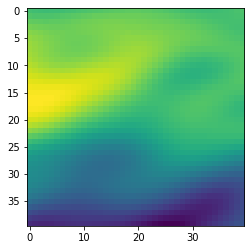

In [7]:
a = dg_train.__getitem__(8)[0]
plt.imshow(a[0,11,:,:,0])
plt.show()

In [8]:
result = model(np.expand_dims(a[0], axis=0)).numpy()
result.shape

(1, 12, 40, 40, 1)

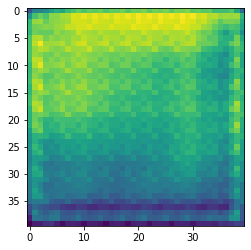

In [9]:
plt.imshow((result[0,11,:,:,0]))
plt.show()

In [10]:
test_data = z_train.sel(time=slice('1979-05-01T16:00:00','1979-05-02T03:00:00' ),level = slice(1),longitude=slice(6,15.75), latitude=slice(55.5,45.75))
test_data = test_data.transpose('time', 'latitude', 'longitude', 'level')
# Normalize
mean = test_data['t'].mean(('time', 'latitude', 'longitude')).compute()
std = test_data['t'].std('time').mean(('latitude', 'longitude')).compute() 
test_data = (test_data['t'] - mean) / std
test_data = np.expand_dims(test_data.values, axis=0)
test_data.shape

(1, 12, 40, 40, 1)

## Results

Original:

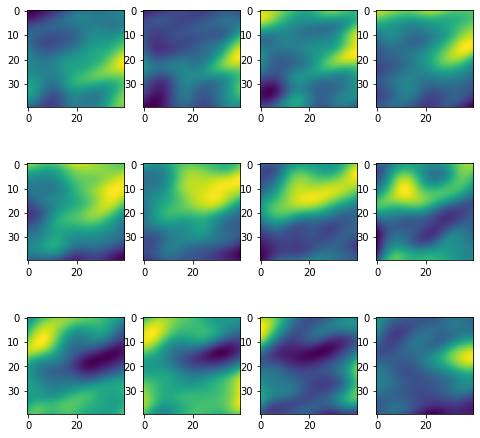

In [11]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 3
for i in range(0, columns*rows):
    img = test_data[0,i,:,:,0]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

Decompressed:

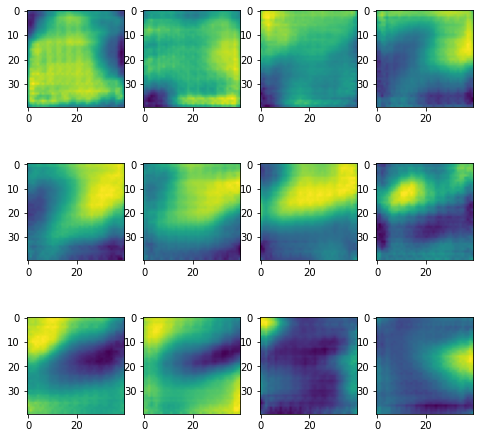

In [12]:
result2 = model(test_data).numpy()
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 3
for i in range(0, columns*rows):
    img = result2[0,i,:,:,0]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

There is a difference between Model 4 and Model 4-2, we can see that the network is now predicting the first images better than the last ones, in model 4 it was the opposite. 